# Pulse propagation in gas-filled hollow core fiber (HCF)

## Single parameter estimation

Estimated alpha: 0.9499987416876081
R²: 0.9999999991185579


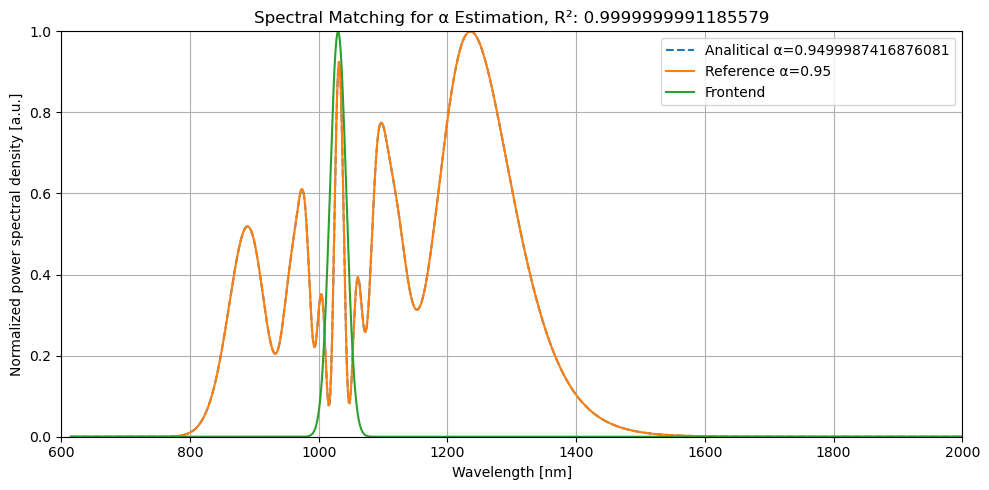

In [86]:
import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq
import warnings
warnings.filterwarnings("error")

# Defining Functions for the simulation

def getPower(amplitude):
    return np.abs(amplitude) ** 2

def getGaussianWavelengthSpectrum(wavelength, wavelength0, wavelength_FWHM):
    return np.exp(-2 * np.log(2) * ((wavelength - wavelength0) / wavelength_FWHM)**2)

def getGaussianPulseTime(time, duration):
    return np.exp(-2*np.log(2)*((time)/(duration))**2)*(1+0j)

def getSpectrumFromPulse(time,pulse_amplitude):
    dt=time[1]-time[0]
    spectrum_amplitude=fftshift(fft(pulse_amplitude))*dt # Take FFT and do shift
    return spectrum_amplitude


def calculate_refractive_index(wavelength_nm, pressure_bar):
    """
    Calculate the refractive index of CO2 at a given wavelength and pressure.
    
    Assumes linear pressure scaling from known value at 1 atm.
    
    Parameters:
    - wavelength_nm: Wavelength in nanometers
    - pressure_bar: Pressure in bar
    
    Returns:
    - Refractive index of CO2 at given pressure
    """
    # Reference data: n_CO2 at 1030 nm and 1 atm (~293 K)
    n_1atm = 1.00045  # Approximate value at 1030 nm from literature
    atm_pressure = 1.01325  # 1 atm in bar

    delta_n = (n_1atm - 1) * (pressure_bar / atm_pressure)
    n = 1 + delta_n
    return n

def calculate_n2(pressure_bar, n2_atm=3.0e-19):
    """
    Calculate the nonlinear refractive index n2 of CO2 at given pressure.

    Parameters:
    - pressure_bar: Pressure in bar
    - n2_atm: n2 of CO2 at 1 atm in cm^2/W (default: 3e-19)

    Returns:
    - n2 in m^2/W
    """
    atm_to_bar = 1.01325
    n2_cm2_W = n2_atm * (pressure_bar / atm_to_bar)
    return n2_cm2_W * 1e-4  # convert to m^2/W

def calculate_gamma(n2_atm, pressure_bar, wavelength, core_diameter):
    """
    Calculate gamma from physical parameters and pressure-scaled n2.

    Parameters:
    - n2_atm: Nonlinear index at 1 atm (in cm^2/W)
    - pressure_bar: Gas pressure in bar
    - wavelength: Wavelength in meters
    - core_diameter: Diameter of fiber core in meters

    Returns:
    - gamma in W^-1·m^-1
    """
    n2 = calculate_n2(pressure_bar, n2_atm)
    core_radius = core_diameter / 2
    A_eff = np.pi * core_radius**2
    gamma = (2 * np.pi * n2) / (wavelength * A_eff)
    return gamma

def mittag_leffler_series(alpha, z, K=100):
    result = 0
    for k in range(K):
        result += z**k / gamma(alpha * k + 1)
    return result

def mittag_leffler_array(alpha, arg_array):
    return np.array([mittag_leffler_series(alpha, element) for element in arg_array], dtype=np.complex128)

# Defining parameters for the simulation
speedoflight_nmpfs = 300                                                         
wavelength0_nm = 1030
wavelength_FWHM_nm = 30
frequency_FWHM = wavelength_FWHM_nm * speedoflight_nmpfs / wavelength0_nm**2
duration_FWHM_fs = 0.44 /  frequency_FWHM
wavelength_nm = np.arange(730, 1331, 1)
spectrum_amplitude_measured = getGaussianWavelengthSpectrum(wavelength_nm, wavelength0_nm, wavelength_FWHM_nm)
I_measured = getPower(spectrum_amplitude_measured)
speedoflight_mps = 3e8
wavelength0_m = wavelength0_nm * 1e-9
wavelength_m = wavelength_nm * 1e-9
wavelength_FWHM_m = wavelength_FWHM_nm * 1e-9
frequency0=speedoflight_mps/wavelength0_m                       
omega0=2*np.pi*frequency0                                   
core_diameter = 250e-6      
pressure = 0.5        
n2_atm = 3.0e-19
true_alpha = 0.95            

# Compute parameters
refractive_index = calculate_refractive_index(wavelength0_m, pressure)
beta0 = refractive_index * (omega0 / speedoflight_mps)
gamma_calculated = calculate_gamma(n2_atm, pressure, wavelength0_m, core_diameter)

# Time, frequency and wavelength grid
N=2**10
Time_window = 50 * duration_FWHM_fs * 1e-15                                        
t = np.linspace(-Time_window/2,Time_window/2,N)                                                                                  
dt = abs(t[1] - t[0])                                   
f = fftshift(fftfreq(N,d=dt))
f_rel = f + frequency0
wavelength_rel = speedoflight_mps / f_rel
sort_idx = np.argsort(wavelength_rel)
wavelength_rel = wavelength_rel[sort_idx]

# Compute inverse Jacobian: dλ/df
inv_jacobian = (wavelength_rel**2) / (speedoflight_mps)

# Prppagation distance
z = 1e10

# Interpolate measured spectrum onto simulated angular frequency grid (omega_rel)
interp_func = interp1d(wavelength_m, I_measured, kind='cubic', fill_value=0, bounds_error=False)
I_measured_on_simgrid = interp_func(wavelength_rel)

# Normalize
I_measured_on_simgrid /= np.max(I_measured_on_simgrid)
#I_measured_on_simgrid = np.clip(I_measured_on_simgrid, 0, None)

initial_pulse = getGaussianPulseTime(t, duration_FWHM_fs * 1e-15)

# Reference measured spectrum (can be simulated with a known alpha)
arg_true = - gamma_calculated * beta0**(1-true_alpha) * np.exp(-1j * np.pi * true_alpha / 2) * getPower(initial_pulse) * z ** true_alpha
pulse_true = initial_pulse * mittag_leffler_array(true_alpha, arg_true)
pulse_true_fft = getSpectrumFromPulse(t,pulse_true)
spec_ref_frequency = getPower(pulse_true_fft)
spec_ref_frequency /= np.max(spec_ref_frequency)
spec_ref = spec_ref_frequency * inv_jacobian
spec_ref /= np.max(spec_ref)

# --- Loss function: spectral L2 distance ---
def spectral_loss(alpha):
    if not (0.9 < alpha < 1.0):
        return np.inf
    arg_model = - gamma_calculated * beta0**(1-alpha) * np.exp(-1j * np.pi * true_alpha / 2) * getPower(initial_pulse) * z ** alpha
    pulse_model = initial_pulse * mittag_leffler_array(alpha, arg_model)
    pulse_model_fft = getSpectrumFromPulse(t,pulse_model)
    spec_model_frequency = getPower(pulse_model_fft)
    spec_model_frequency /= np.max(spec_model_frequency)
    spec_model = spec_model_frequency * inv_jacobian
    spec_model /= np.max(spec_model)
    return np.sum((spec_model - spec_ref)**2)

# --- another loss function ---
def spectral_loss2(alpha):
    if not (0.9 < alpha < 1.0):
        return np.inf
    arg_model = - gamma_calculated * beta0**(1-alpha) * np.exp(-1j * np.pi * true_alpha / 2) * getPower(initial_pulse) * z ** alpha
    pulse_model = initial_pulse * mittag_leffler_array(alpha, arg_model)
    pulse_model_fft = getSpectrumFromPulse(t,pulse_model)
    spec_model_frequency = getPower(pulse_model_fft)
    spec_model_frequency /= np.max(spec_model_frequency)
    spec_model = spec_model_frequency * inv_jacobian
    spec_model /= np.max(spec_model)
    return np.sum((spec_model - np.mean(spec_ref))**2)

# --- Estimate alpha ---
res = minimize_scalar(spectral_loss, bounds=(0.9, 1.0), method='bounded')
estimated_alpha = res.x
print(f"Estimated alpha: {estimated_alpha}")

# Fitted spectrum with estimated alpha
arg_fit = - gamma_calculated * beta0**(1-estimated_alpha) * np.exp(-1j * np.pi * true_alpha / 2) * getPower(initial_pulse) * z ** estimated_alpha
pulse_fit = initial_pulse * mittag_leffler_array(estimated_alpha, arg_fit)
pulse_fit_fft = getSpectrumFromPulse(t, pulse_fit)
spec_fit_frequency = getPower(pulse_fit_fft)
spec_fit_frequency /= np.max(spec_fit_frequency)
spec_fit = spec_fit_frequency * inv_jacobian
spec_fit /= np.max(spec_fit)

# Frontend spectrum
spec_amplitude_frontend = getGaussianWavelengthSpectrum(wavelength_rel, wavelength0_m, wavelength_FWHM_m)
spec_frontend = getPower(spec_amplitude_frontend)

# Residual sum of squares
ss_res = spectral_loss(estimated_alpha)
# Total sum of squares
ss_tot = spectral_loss2(estimated_alpha)
# R^2 value
r_squared = 1 - (ss_res / ss_tot)
print(f"R²: {r_squared}")

# --- Plot comparison ---
plt.figure(figsize=(10,5))
plt.plot(wavelength_rel * 1e9, spec_fit, label=f"Analitical α={estimated_alpha}", linestyle='--')
plt.plot(wavelength_rel * 1e9, spec_ref, label=f"Reference α={true_alpha}")
plt.plot(wavelength_rel * 1e9, spec_frontend, label="Frontend")
plt.axis([600,2000,0,1])
plt.xlabel("Wavelength [nm]")
plt.ylabel("Normalized power spectral density [a.u.]")
plt.title(f"Spectral Matching for α Estimation, R²: {r_squared}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()